<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Using Natural Language Processing (NLP) Modelling to Predict Desktop CPU Brand Popularity

# Part 3 - Data Cleaning and EDA
### Contents:
- [Data Cleaning](#Data-Cleaning)
- [Stopwords](#Stopwords)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Lemmatizing/Stemming](#Lemmatizing/Stemming)

In [4]:
#Library imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

import re

Please install the spacy (https://spacy.io/usage) library through any of the following methods:

#### pip install

In [182]:
# pip install -U spacy
# python -m spacy download en_core_web_sm

**conda install**

In [183]:
# conda install -c conda-forge spacy
# python -m spacy download en_core_web_sm

In [3]:
import spacy

---

# Data Cleaning

#### Datasets importing, merging, and cleaning

In [5]:
#read in the AMD and Intel Data

amd = pd.read_csv('./amd_csv.csv')
intel = pd.read_csv('./intel_csv.csv')

df = pd.concat([amd,intel], axis = 0)

Following was done to the reddit title and posts:

- ```subreddit``` column was changed to ```subreddit_isAMD``` and values were changed so that ```r/AMD``` is the positive class.
- ```title``` and ```selftext``` columns were merged to the ```text``` column.
- Links were removed from the posts.
- Markdown codes such as ```‘&amp;#x200B;’```, ```‘&lt;’```, ```‘&gt;’```, ```/n``` were removed.
- Non-ASCII and extended ASCII characters will be removed by the vectorizers and will not be cleaned here.


In [6]:
#changing the subreddit column to reflect r/AMD as the postive class
df['subreddit'] = df['subreddit'].map(lambda x: 1 if x == "Amd" else 0)
df.rename(columns = {'subreddit': 'subreddit_isAMD'}, inplace = True)
df.reset_index(drop=True, inplace=True)

#merging title and selftext
df['text'] = df['title'] + ' ' + df['selftext']

In [7]:
#removing links
df['text'] = df['text'].map(lambda x: re.sub(r"http.:+[^\s]+[\w]", '', x))
#removing &amp;
df['text'] = df['text'].map(lambda x: x.replace('&amp;',''))
#removing #x200B;
df['text'] = df['text'].map(lambda x: x.replace('#x200B;',''))
#removing &lt;
df['text'] = df['text'].map(lambda x: x.replace('&lt;',''))
#removing &gt;
df['text'] = df['text'].map(lambda x: x.replace('&gt;',''))
#removing \n
df['text'] = df['text'].map(lambda x: x.replace('\n',''))


In [8]:
#exporting the DataFrame for model training
df.to_csv('train_csv.csv', index = False)

---

# Stopwords

spaCy english stopwords library was chosen for this project as it has a longer list of english stopwords as compared to NLTK.

'AMD' and 'Intel' will be added to the stopwords as they are dead giveaway words for the topic at hand.

In [9]:
#loading the english language small model of spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words

#saving to a list variable in order to add more words to the list
sw_spacy = list(sw_spacy)

In [10]:
#creating a new list of stopwords and removing those with apostrophe as those will be removed by the tokenizers anyways
new_spacy = []
for word in sw_spacy:
    if "'" not in word:
        new_spacy.append(word)

new_spacy.append('amd')    #adding dead giveaway words
new_spacy.append('intel')
new_spacy.append('ll')     #adding words that caused Warnings when running a model
new_spacy.append('ve')
new_spacy.append('nt')

---

# Exploratory Data Analysis

## CountVectorizer

CountVectorizer converts a collection of text documents to a matrix of token counts. A token is the constituent parts of the original text and by default it will extract out the words of the text and removing all the punctuations. It will return a sparse matrix of all the word counts for a given row in our DataFrame.

Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

### Top Words for CountVectorizer

In [29]:
#Setting X and y
X = df['text']
y = df['subreddit_isAMD']

#instantiate vectorizer
cvec = CountVectorizer(
    stop_words= new_spacy,   #adding stop
    strip_accents = 'ascii', #removing non-ASCII and extended ASCII characters
    max_features = 5000,     #setting arbitrary value
    )

#fitting and transforming
X = cvec.fit_transform(X)

#saving results into a sparse DataFrame
X_df = pd.DataFrame.sparse.from_spmatrix(
    X,
    columns=cvec.get_feature_names_out(),
)

#adding the target values to the DataFrame
words_df = pd.concat([y, X_df], axis = 1)

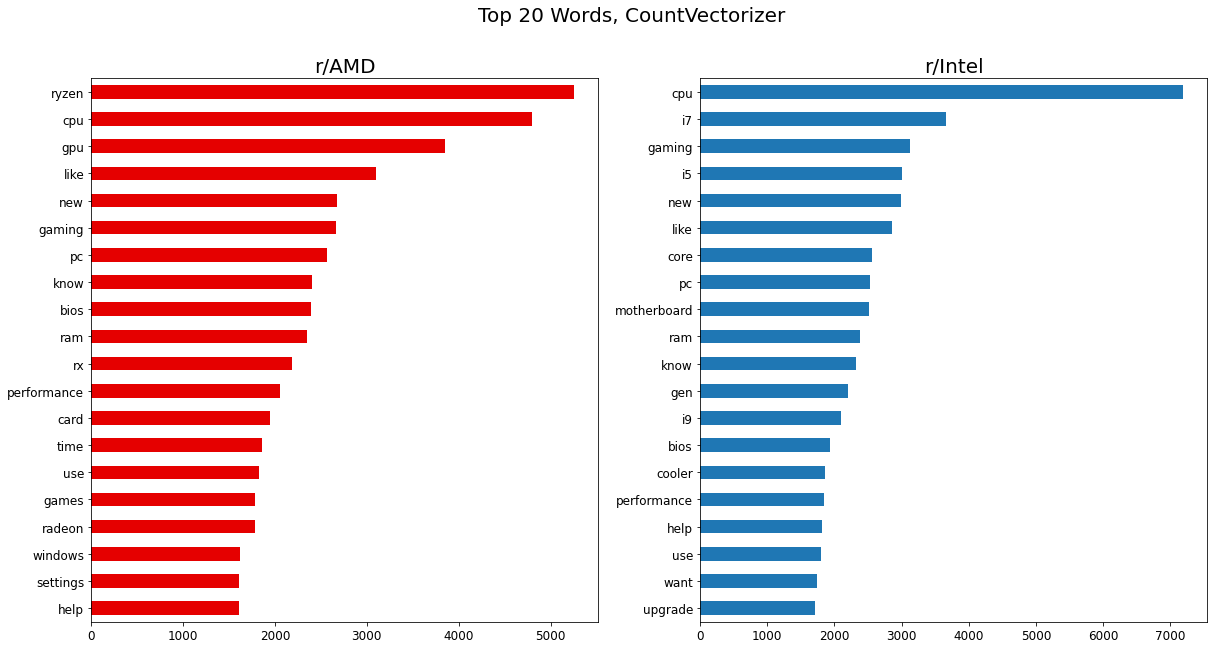

In [30]:
#plotting top words for vectorizer

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Top 20 Words, CountVectorizer', size = 20)

words_df[words_df['subreddit_isAMD'] == 1].drop(columns='subreddit_isAMD').sum().sort_values().tail(20).plot(kind='barh', fontsize = 12, color = ('xkcd:red'), ax=ax1)

ax1.set_title('r/AMD', size = 20);

words_df[words_df['subreddit_isAMD'] == 0].sum().sort_values().tail(20).plot(kind='barh', fontsize = 12, ax=ax2)

ax2.set_title('r/Intel', size = 20);

From the top words seen above, we see words that are topic of interest like cpu, gaming, and pc for both . More interestingly, here we see brand specific product model names like ryzen, radeon, rx for ```r/AMD``` and i7, i5, i9 for ```r/Intel```.

### Top Bigrams for CountVectorizer

In [26]:
#Setting X and y
X = df['text']
y = df['subreddit_isAMD']

#instantiate vectorizer
cvec = CountVectorizer(
    stop_words= new_spacy,   #adding stop
    strip_accents = 'ascii', #removing non-ASCII and extended ASCII characters
    max_features = 5000,     #setting arbitrary value
    ngram_range = (2,2),    #calling out only the 2-grams
    )

#fitting and transforming
X = cvec.fit_transform(X)

#saving results into a sparse DataFrame
X_df = pd.DataFrame.sparse.from_spmatrix(
    X,
    columns=cvec.get_feature_names_out(),
)

#adding the target values to the DataFrame
words_df = pd.concat([y, X_df], axis = 1)

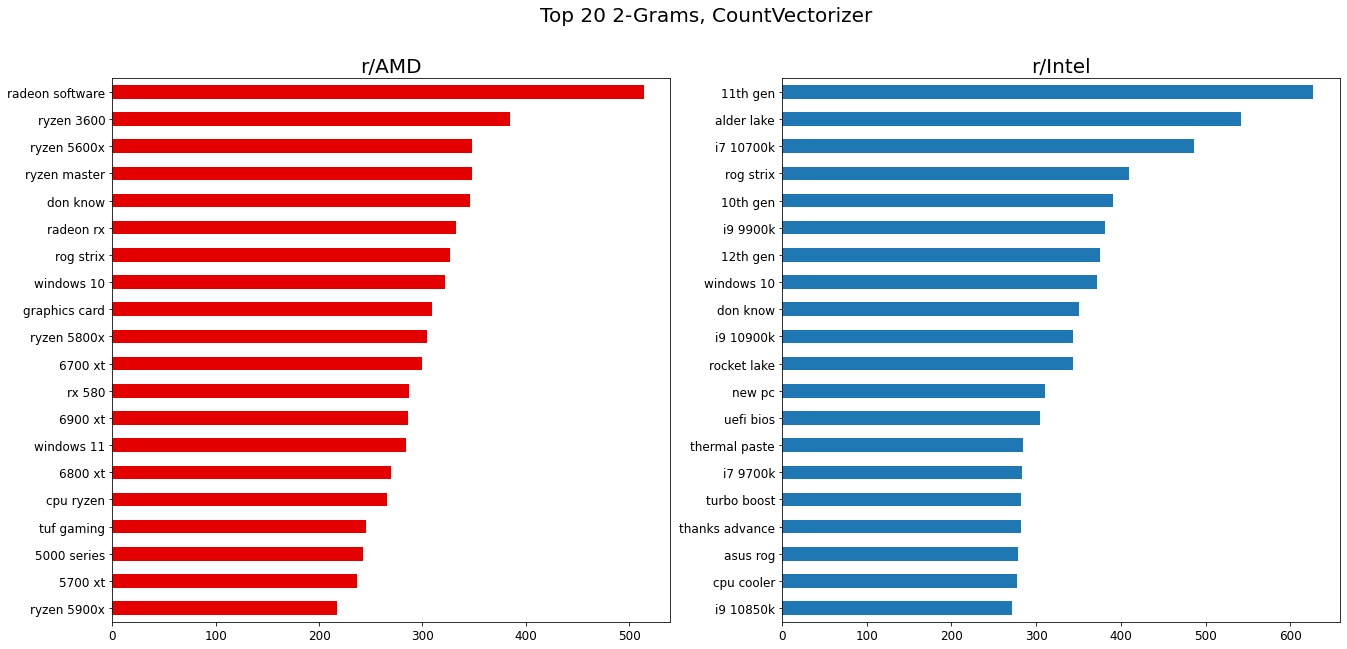

In [28]:
#plotting top 2-grams for vectorizer

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,10))
fig.suptitle('Top 20 2-Grams, CountVectorizer', size = 20)

words_df[words_df['subreddit_isAMD'] == 1].drop(columns='subreddit_isAMD').sum().sort_values().tail(20).plot(kind='barh', fontsize = 12, color = ('xkcd:red'), ax=ax1)

ax1.set_title('r/AMD', size = 20);

words_df[words_df['subreddit_isAMD'] == 0].sum().sort_values().tail(20).plot(kind='barh', fontsize = 12, ax=ax2)

ax2.set_title('r/Intel', size = 20);

We see a continuation of the trend from the top words above. However, now more brand specific product model names and stock keeping units (SKUs) are appearing in the 2-grams. Names like ryzen 3600, ryzen 5600x, radeon rx, etc. for ```r/AMD``` and alder lake, i7 10700k, i9 9900k for ```r/Intel```. From here we see that the top features for the model will most likely be made up of these brand specific model names/SKUs.

## Term Frequency-Inverse Document Frequency (TF-IDF) Vectorizer


Term Frequency-Inverse Document Frequency (TF-IDF) Vectorizer will take in a text and tokenize it into their constituents. However, the difference as compared to CountVectorizer though is that TFIDF will compute not only the frequency of the token, but also the inverse document frequency (negative log of the ratio the token appears in all given documents). Thus, tokens that occur often in one document but don't occur in many documents contain more predictive power.

Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

### Top Words for TFIDFVectorizer

In [22]:
#Setting X and y
X = df['text']
y = df['subreddit_isAMD']

#instantiate vectorizer
tvec = TfidfVectorizer(
    stop_words= new_spacy,
    strip_accents = 'ascii',
    max_features = 5000,
)
#fitting and transforming
X = tvec.fit_transform(X)

#saving results into a sparse DataFrame
X_df = pd.DataFrame.sparse.from_spmatrix(
    X,
    columns=tvec.get_feature_names_out(),
)
#adding the target values to the DataFrame
words_df = pd.concat([y, X_df], axis = 1)

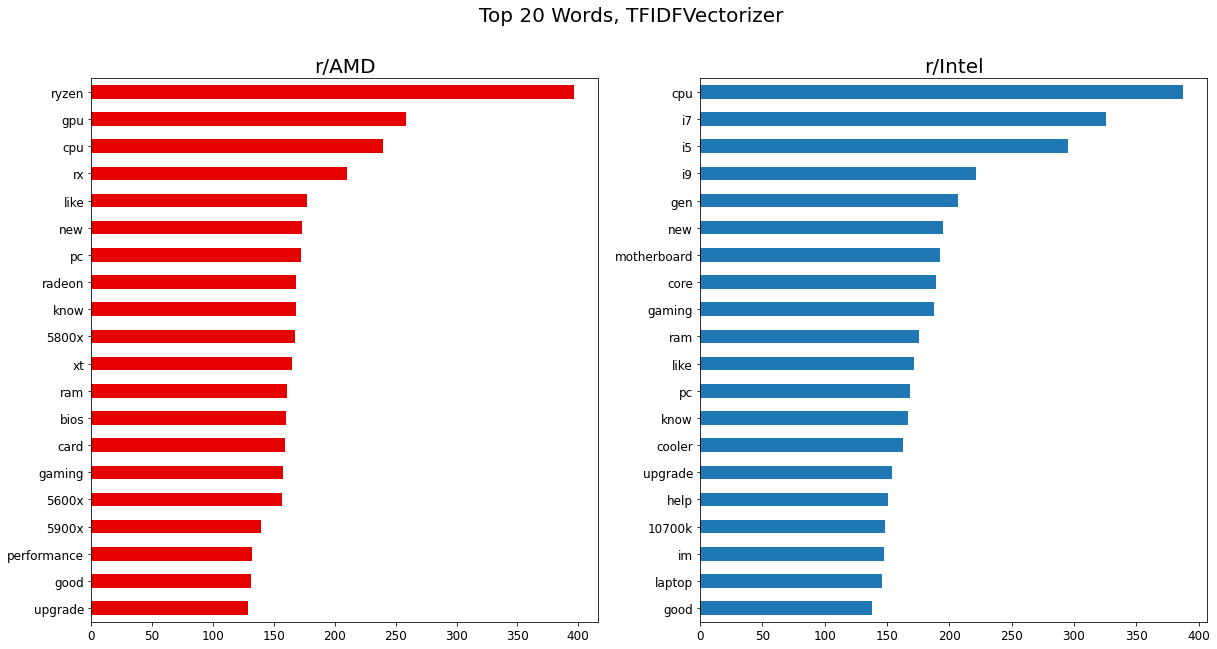

In [24]:
#plotting top words for vectorizer

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Top 20 Words, TFIDFVectorizer', size = 20)

words_df[words_df['subreddit_isAMD'] == 1].drop(columns='subreddit_isAMD').sum().sort_values().tail(20).plot(kind='barh', fontsize = 12, color = ('xkcd:red'), ax=ax1)

ax1.set_title('r/AMD', size = 20);

words_df[words_df['subreddit_isAMD'] == 0].sum().sort_values().tail(20).plot(kind='barh', fontsize = 12, ax=ax2)

ax2.set_title('r/Intel', size = 20);

From the top words seen above, we see the same words as per CountVectorizer that are topic of interest like cpu, gaming, and pc across both subreddits. We see also see the same brand specific product model names like ryzen, radeon, rx for ```r/AMD``` and i7, i5, i9 for ```r/Intel```. However, the rank for each of the brand specific product model names has increased. This is especially so for ```r/Intel``` whereby the all Desktop CPU model names are now in the top 5 (i7, i5, and i9).

### Top Bigrams for TFIDF Vectorizer

In [31]:
#Setting X and y
X = df['text']
y = df['subreddit_isAMD']

#instantiate vectorizer
tvec = TfidfVectorizer(
    stop_words= new_spacy,
    strip_accents = 'ascii',
    max_features = 5000,
    ngram_range = (2,2),
)
#fitting and transforming
X = tvec.fit_transform(X)

#saving results into a sparse DataFrame
X_df = pd.DataFrame.sparse.from_spmatrix(
    X,
    columns=tvec.get_feature_names_out(),
)
#adding the target values to the DataFrame
words_df = pd.concat([y, X_df], axis = 1)

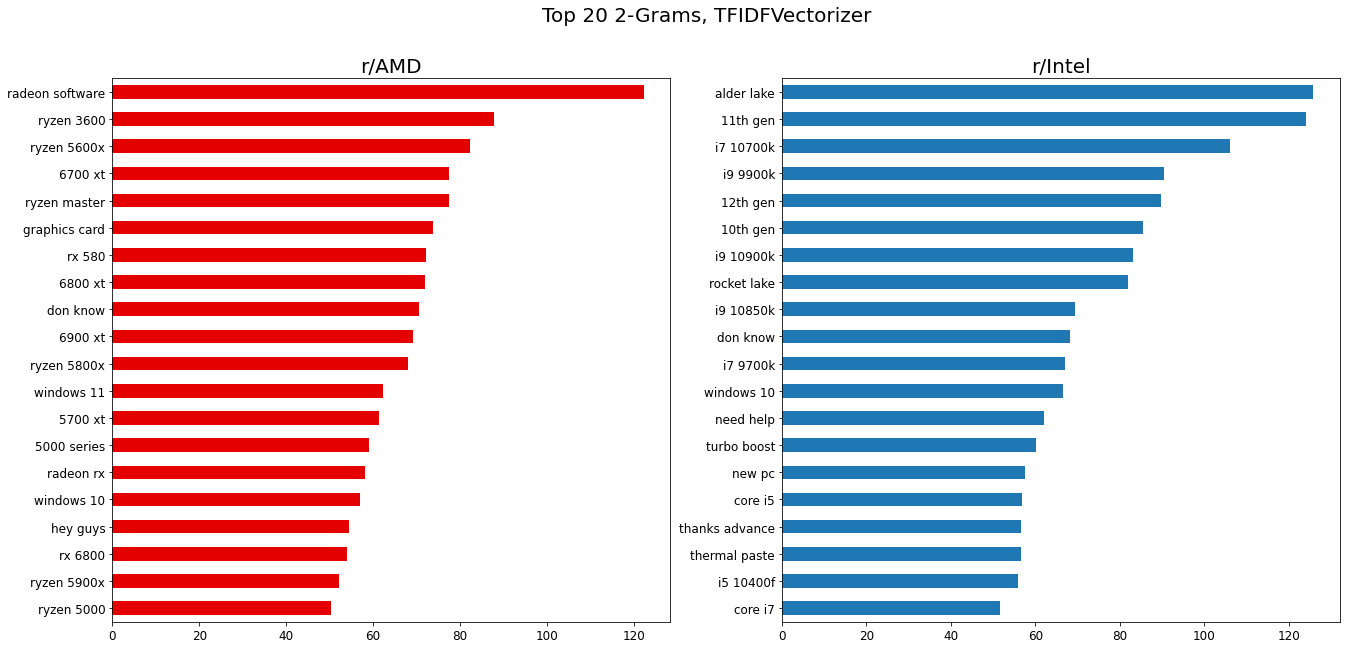

In [33]:
#plotting top words for vectorizer

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,10))
fig.suptitle('Top 20 2-Grams, TFIDFVectorizer', size = 20)

words_df[words_df['subreddit_isAMD'] == 1].drop(columns='subreddit_isAMD').sum().sort_values().tail(20).plot(kind='barh', fontsize = 12, color = ('xkcd:red'), ax=ax1)

ax1.set_title('r/AMD', size = 20);

words_df[words_df['subreddit_isAMD'] == 0].sum().sort_values().tail(20).plot(kind='barh', fontsize = 12, ax=ax2)

ax2.set_title('r/Intel', size = 20);

We see the same trend as explored in the previous graphs with brand specific product model names dominating the bigram charts for both subreddits.

---

## Lemmatizing/Stemming

Lemmatizing/Stemming is a process whereby the tokens are reducing the word to its root word or lemma. The main aim is to remove suffixes like plurality,-er,-tion etc. as the root word most likely describes the same thing but in different forms. However, lemmatizing/stemming only works for words with a dictionary root form. From the EDA done above, we predict that the best features will be made up of those brand specific model names/SKUs of which there is not any dictionary root form.

In [34]:
X = df['text']
y = df['subreddit_isAMD']

cvec = CountVectorizer(
    stop_words= new_spacy,
    strip_accents = 'ascii',
    ngram_range = (1,1),
    max_features = 5000,
    )

X = cvec.fit_transform(X)
len(list(cvec.get_feature_names_out()))

#instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatize tokens.
tokens_lem = [lemmatizer.lemmatize(w) for w in list(cvec.get_feature_names_out())]

#Extracting list of words that has been lemmatized
for x, y in zip(list(cvec.get_feature_names_out()), tokens_lem):
    if x != y:
        print(x, y)

30s 30
40s 40
50s 50
60s 60
70s 70
80s 80
90s 90
accounts account
adapters adapter
adds add
adjustments adjustment
advantages advantage
advices advice
aesthetics aesthetic
affects affect
alternatives alternative
amds amd
amounts amount
answers answer
apologies apology
applications application
areas area
articles article
artifacts artifact
aspects aspect
ass as
assassins assassin
attacks attack
avengers avenger
averages average
beats beat
beeps beep
benchmarks benchmark
benefits benefit
betas beta
bits bit
blocks block
boards board
boosts boost
boots boot
borderlands borderland
bots bot
bottlenecks bottleneck
boxes box
brackets bracket
brands brand
breaks break
brothers brother
browsers browser
bs b
bucks buck
bugs bug
builds build
buyers buyer
cables cable
caches cache
capabilities capability
capacitors capacitor
caps cap
cards card
cas ca
cases case
causes cause
ces ce
chances chance
changes change
channels channel
cheers cheer
chips chip
choices choice
circumstances circumstance
clai

In [35]:
# Instantiate PorterStemmer.
p_stemmer = PorterStemmer()

#stem tokens
tokens_stem = [p_stemmer.stem(w) for w in list(cvec.get_feature_names_out())]

#Extracting list of words that has been stemmed
for x, y in zip(list(cvec.get_feature_names_out()), tokens_stem):
    if x != y:
        print(x, y)

100fps 100fp
120fps 120fp
144fps 144fp
1usmus 1usmu
30fps 30fp
30s 30
40s 40
50s 50
60fps 60fp
60s 60
70s 70
80plus 80plu
80s 80
90s 90
9900ks 9900k
ability abil
able abl
absolute absolut
absolutely absolut
accelerated acceler
acceleration acceler
acceptable accept
accidentally accident
accommodate accommod
according accord
accounted account
accounts account
accurate accur
achieve achiev
achieved achiev
acquired acquir
acting act
activate activ
activated activ
active activ
actually actual
adapter adapt
adapters adapt
adaptive adapt
added ad
adding ad
addition addit
additional addit
additionally addit
addressed address
adds add
adequate adequ
adjusted adjust
adjusting adjust
adjustment adjust
adjustments adjust
adobe adob
adrenaline adrenalin
advance advanc
advanced advanc
advantage advantag
advantages advantag
advertised advertis
advice advic
advices advic
advise advis
advised advis
aesthetics aesthet
affected affect
affecting affect
affects affect
affordable afford
afterburner afterbu

products product
professional profession
profile profil
profiles profil
programming program
programs program
projects project
promised promis
proofing proof
properly properli
properties properti
pros pro
protection protect
provide provid
provided provid
provider provid
provides provid
providing provid
pulled pull
pulling pull
pulls pull
pulse puls
purchase purchas
purchased purchas
purchasing purchas
purely pure
purpose purpos
purposes purpos
pushed push
pushing push
puts put
putting put
qualification qualif
quality qualiti
questions question
quickly quickli
racing race
radeonTM radeontm
radiator radiat
rads rad
raise rais
raised rais
raising rais
rampage rampag
ramps ramp
rams ram
randomly randomli
range rang
ranges rang
ranging rang
ranked rank
ranks rank
rapidly rapidli
rarely rare
rated rate
rates rate
rating rate
raytracing raytrac
reached reach
reaches reach
reaching reach
readily readili
reading read
readings read
reads read
ready readi
realised realis
realistic realist
realisti

Looking through the list of words that was lemmatized, we do not see any brand specific model names/SKUs that has been cut short but in those stemmed words, we see words like 9900ks having its -s removed because the PorterStemmer() took it as a plural form or even alderlake which has had its -e removed.

At the end of the day, the purpose of lemmatizing/stemming is to congregate root words together and for our specific subject matter, this is not required. However, this will still be used as a measure in model training to determine if it affectes our model accuracy